<img src="https://upload.wikimedia.org/wikipedia/commons/8/89/TheNorthFace_logo.svg" alt="THE NORTH FACE LOGO" width="50%" />

# The North Face e-commerce : boosting online sales !

## Company's Description 📇

The North Face is an American outdoor recreation product company, founded in 1968 to supply climbers. The North Face produces clothing, footwear, and outdoor equipment. By the late 1990s customers had expanded beyond outdoor enthusiasts and in the 2000s it became a fashion style symbol.


## Project 🚧

The marketing department would like to take advantage of machine learning solutions to boost online sales on the website : https://www.thenorthface.fr/

They have identified two major solutions that could have a huge effect on the conversion rates :
- Deploying a **recommender system** that will allow to suggest additionnal products to users, that are similar to the items they are already interested in. The recommendations could be materialized by a "you might also be interested by these products..." section that would appear on each product page of the website.
- Improving the structure of the products catalog thanks to **topic extraction**. The idea is to use unsupervised methods to challenge the existing categories : is it possible to find new categories of product that would be more suitable for the navigation on the website ?

## Goals 🎯

The project can be cut into three steps :

1. Identify groups of products that have similar descriptions.

2. Use the groups of similar products to build a simple recommender system algorithm.

3. Use topic modeling algorithms to automatically assess the latent topics present in the item descriptions.

## Scope of this project 🖼️

In this project, you'll work with a corpus of item descriptions from The North Face's product catalog. Data can be found here: 

👉👉<a href="https://www.kaggle.com/cclark/product-item-data?select=sample-data.csv" target="_blank"> The North Face product catalog</a> 👈👈


## Helpers 🦮

To help you achieve this project, here are a few tips that should help you: 

### Preprocessing of textual data

- First, you'll have to make some preprocessings to clean the corpus (in particular, don't forget to handle stop words and to lemmatize the documents). For this step, you'll need `pandas` and `spacy`.

- Then, you can to encode the texts with **TF-IDF transformation** (this can be done with scikit learn's `TFIDFVectorizer`)

### Part 1 : Groups of products with similar descriptions

For this part, you'll have to train a **clustering model** that will create groups of products for which the descriptions are "close" to each other. 
- You can use `DBSCAN` to make some clustering on the TF-IDF matrix. When dealing with texts, the distance metric to be used is "cosine" instead of "euclidean". You have to find some values for `eps` and `min_samples` that allow to get 10-20 clusters and not too many outliers.
- You can display a `wordcloud` for each cluster to analyze the results and see if the groups contain different words.

### Part 2 - Recommender system

Then, you can use the cluster ids from part 1 to build a **recommender system**. The aim is to be able to suggest to a user some products that are similar to the ones he is interested in. To do this, we will consider that products belonging to the same cluster are similar.

- Create a function named `find_similar_items` that takes an argument `item_id` representing the id of a product, and that returns a list of 5 item ids that belong to the same cluster as the product passed in argument
- Use python's `input()` function to allow the user to choose a product and perform some suggestions of similar items

### Part 3 : Topic modeling

*This part is independant from the two others.*

The aim is to use an LSA model to automatically extract latent topics in the products' descriptions.

- Use TruncatedSVD to make some topic extraction from the TF-IDF matrix. You can try values for `n_components` that allow to get 10-20 topics. Save the encoded matrix into a variable named `topic_encoded_df`.
- Contrary to clustering, LSA allows to map each document to a mixing of several topics. For this reason, it's a bit more difficult to interpret the topics as categories : one document can actually be related to several topics at a time. To make things easier, consider extracting the main topic of each document.
- As in part 1, you can display `wordclouds` to analyze the results.

## Deliverable 📬

To complete this project, your team should: 

- Train at least one **clustering model** on the corpus and display wordclouds describing the clusters
- Develop a simple python code that allows a user to type the id of a product he's interested in, and then get a list of similar items
- Train at least one **TruncatedSVD model** on the corpus and display wordclouds describing the latent topics


### --- Imports ---

In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import DBSCAN
from sklearn.decomposition import TruncatedSVD
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score
import spacy
from bs4 import BeautifulSoup
import re
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [2]:
catalog = pd.read_csv('sample-data.csv', index_col=0)

In [3]:
catalog.head()

,description
id,
1,Active classic boxers - There's a reason why o...
2,Active sport boxer briefs - Skinning up Glory ...
3,Active sport briefs - These superbreathable no...
4,"Alpine guide pants - Skin in, climb ice, switc..."
5,"Alpine wind jkt - On high ridges, steep ice an..."


### --- Processing ---

In [4]:
# Basic stats about the dataframe
print(f"Number of rows : {catalog.shape[0]}")
print()

print("Basic info: ")
catalog.info()
print()

print("Display of catalog: ")
display(catalog.head())
print()

print("Basics statistics: ")
data_desc = catalog.describe(include='all')
display(data_desc)
print()

print("Percentage of missing values: ")
display(pd.DataFrame(np.round(100*catalog.isnull().sum()/catalog.shape[0]), columns=['% missing values']))

Number of rows : 500

Basic info: 
<class 'pandas.core.frame.DataFrame'>
Index: 500 entries, 1 to 500
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   description  500 non-null    object
dtypes: object(1)
memory usage: 7.8+ KB

Display of catalog: 


,description
id,
1,Active classic boxers - There's a reason why o...
2,Active sport boxer briefs - Skinning up Glory ...
3,Active sport briefs - These superbreathable no...
4,"Alpine guide pants - Skin in, climb ice, switc..."
5,"Alpine wind jkt - On high ridges, steep ice an..."



Basics statistics: 


,description
count,500
unique,500
top,Active classic boxers - There's a reason why o...
freq,1



Percentage of missing values: 


,% missing values
description,0.0


### --- Text cleaning ---

In [5]:
nlp = spacy.load('en_core_web_sm')

# Preprocess text
def preprocess_text(text):
    soup = BeautifulSoup(text, 'html.parser')
    cleaned_text = soup.get_text(separator=" ")  # convert to text and replace HTML tags with space
    cleaned_text = re.sub(r'[^\w\s]', '', cleaned_text)  # remove punctuation
    cleaned_text = re.sub(r'\d+', '', cleaned_text)  # remove numbers
    cleaned_text = re.sub(r'\b\w\b', '', cleaned_text)  # remove single letters
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text)  # replace multiple spaces with single space
    doc = nlp(cleaned_text.strip())  # remove trailing and leading spaces
    # Remove specific words
    words_to_remove = ['oz', 'size', 'detail', 'program', 'weight']
    lemmatized_text = " ".join([token.lemma_ for token in doc if not token.is_stop and token.lemma_ not in words_to_remove and len(token.lemma_) > 1])
    return lemmatized_text.lower()  # return lowercase lemmatized text

In [6]:
catalog['description_cleaned'] = catalog['description'].apply(preprocess_text)

In [7]:
catalog.head()

,description,description_cleaned
id,,
1,Active classic boxers - There's a reason why o...,active classic boxer reason boxer cult favorit...
2,Active sport boxer briefs - Skinning up Glory ...,active sport boxer brief skin glory require mo...
3,Active sport briefs - These superbreathable no...,active sport brief superbreathable nofly brief...
4,"Alpine guide pants - Skin in, climb ice, switc...",alpine guide pant skin climb ice switch rock t...
5,"Alpine wind jkt - On high ridges, steep ice an...",alpine wind jkt high ridge steep ice alpine ja...


In [8]:
catalog.iloc[1]['description_cleaned']

'active sport boxer brief skin glory require movement boxer decide poach route formfitte active sport boxer brief breathable polyester recycle fabric fastwicke dry quickly spandex stretch seamless waistband soft leg edge will not roll bind gussete flatsewn inseam offset prevent innerthigh chafe flyfree smooth panel recyclable common threads recycling program details stretch mesh provide support openweave mesh airflow wick efficiently dry fast seamless construction flatsewn gussete inseam set forward prevent innerthigh chafe flyfree support inseam fabric polyester recycle spandex moisturewicking performance recyclable common threads recycling program weight israel'

In [9]:
# Encode the texts with TF-IDF transformation

vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(catalog['description_cleaned'])

### --- Part 1 : Groups of products with similar descriptions ---

In [10]:
# Prepare a list of eps and min_samples
eps_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0]
min_samples_values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 20, 25]

# Variables to store the best parameters and their corresponding best score
best_eps = 0
best_min_samples = 0
best_score = -1
best_outliers_percentage = 100

# Loop over potential parameter values
for eps in eps_values:
    for min_samples in min_samples_values:
        # Initialize DBSCAN with the current parameters
        dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric="cosine")
        # Perform clustering
        clusters = dbscan.fit_predict(X)
        
        # Calculate the number of clusters (excluding outliers)
        n_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)
        
        # Calculate the percentage of outliers
        n_outliers = np.sum(clusters == -1)
        n_total = clusters.shape[0]
        outliers_percentage = (n_outliers / n_total) * 100
        
        # Check if more than one cluster is identified
        if len(set(clusters)) >= 10 and len(set(clusters)) <= 20:
            # Calculate silhouette score
            score = silhouette_score(X, clusters)
            # Print current parameters, number of clusters and percentage of outliers
            print(f'eps={eps}, min_samples={min_samples}, num_clusters={n_clusters}, outliers_percentage={outliers_percentage:.2f}%')
            
            # If the score is better than the current best score, update best parameters and best score
            if outliers_percentage < best_outliers_percentage and outliers_percentage != 0:
                best_eps = eps
                best_min_samples = min_samples
                best_score = score
                best_outliers_percentage = outliers_percentage

# Print best parameters and their corresponding best score
print(f'Best eps={best_eps}, best min_samples={best_min_samples}, outliers={best_outliers_percentage}%')

eps=0.1, min_samples=3, num_clusters=9, outliers_percentage=94.20%
eps=0.2, min_samples=3, num_clusters=12, outliers_percentage=90.80%
eps=0.3, min_samples=3, num_clusters=16, outliers_percentage=84.20%
eps=0.4, min_samples=4, num_clusters=15, outliers_percentage=80.60%
eps=0.4, min_samples=5, num_clusters=10, outliers_percentage=84.60%
eps=0.5, min_samples=5, num_clusters=13, outliers_percentage=71.20%
eps=0.5, min_samples=6, num_clusters=11, outliers_percentage=73.60%
eps=0.6, min_samples=5, num_clusters=19, outliers_percentage=55.80%
eps=0.6, min_samples=6, num_clusters=14, outliers_percentage=61.80%
eps=0.6, min_samples=7, num_clusters=10, outliers_percentage=67.20%
eps=0.7, min_samples=5, num_clusters=16, outliers_percentage=21.40%
eps=0.7, min_samples=6, num_clusters=15, outliers_percentage=25.40%
eps=0.7, min_samples=7, num_clusters=14, outliers_percentage=32.60%
eps=0.7, min_samples=8, num_clusters=10, outliers_percentage=41.20%
Best eps=0.7, best min_samples=5, outliers=21.4%


Number of clusters:  17


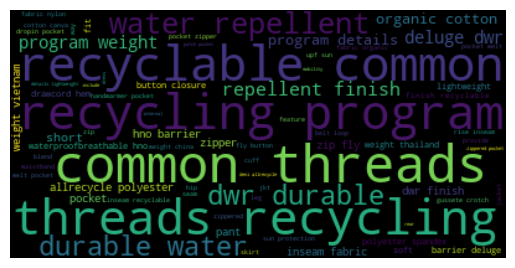

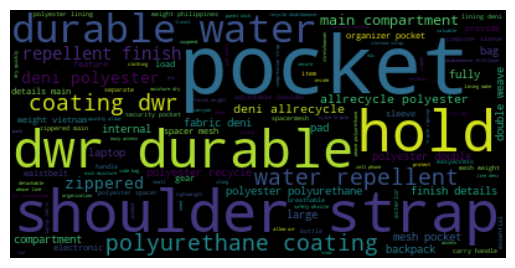

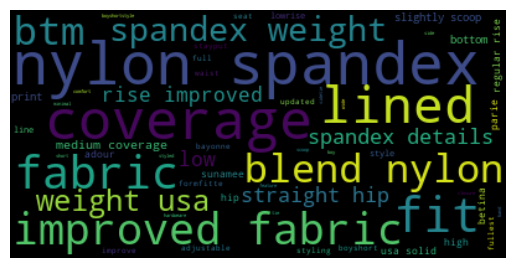

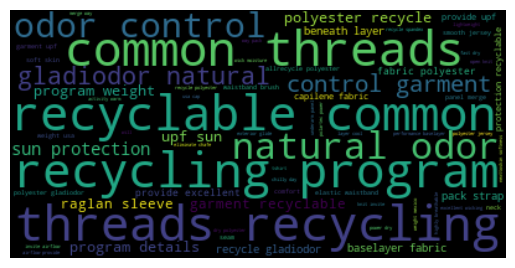

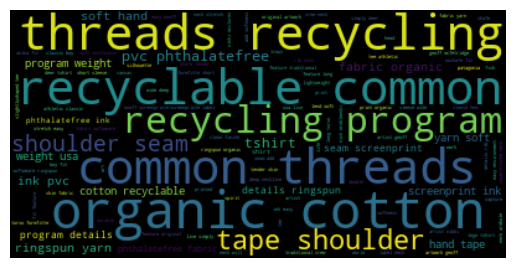

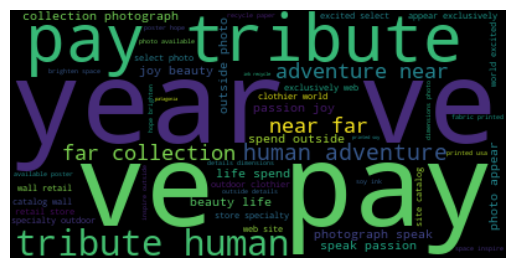

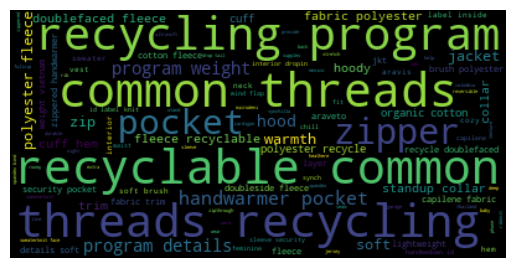

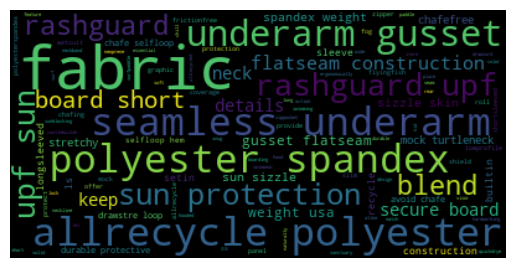

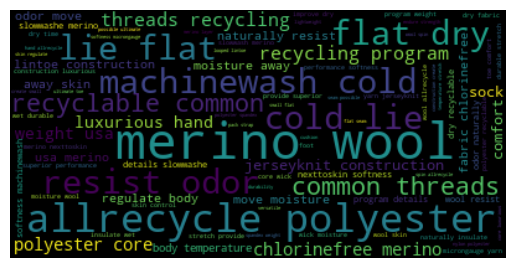

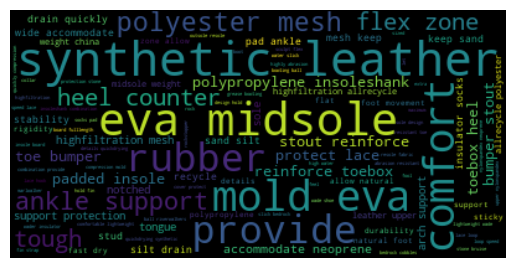

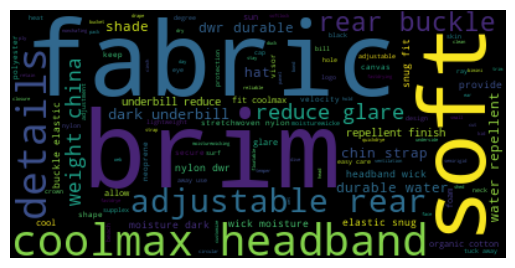

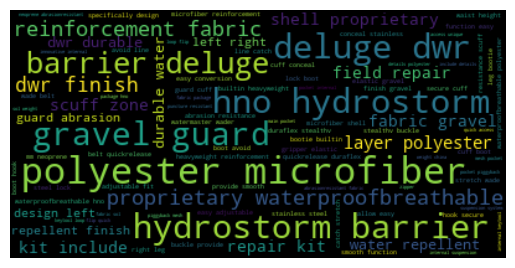

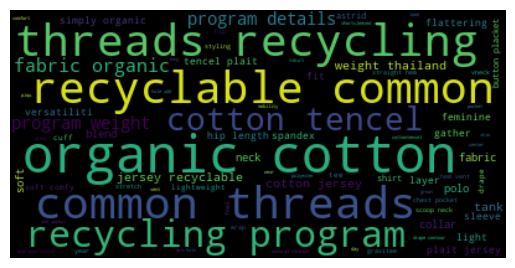

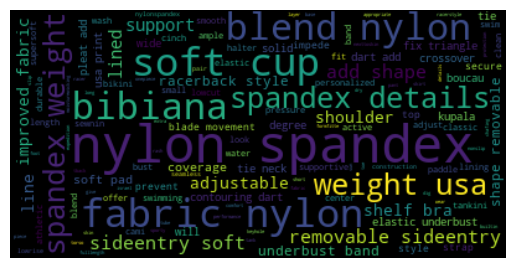

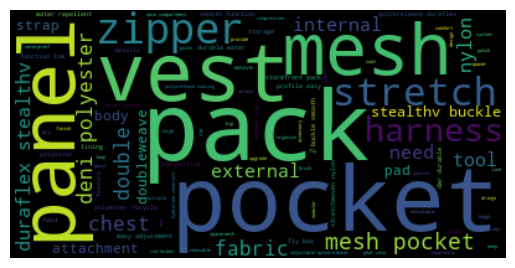

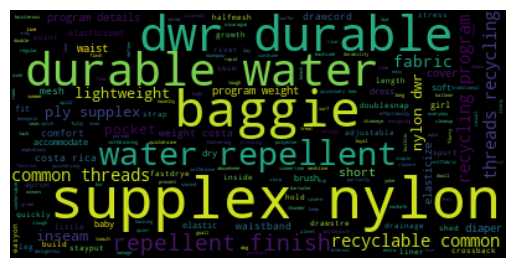

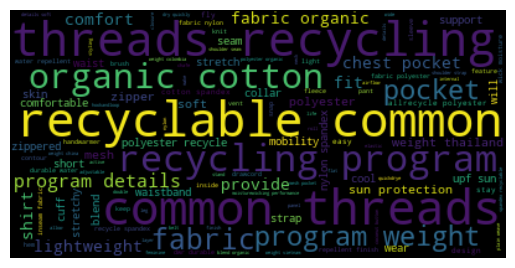

In [11]:
# Display word clouds
clustering = DBSCAN(eps=0.7, min_samples=5, metric="cosine").fit(X)
catalog['cluster'] = clustering.labels_
print("Number of clusters: ", len(catalog['cluster'].unique()))
for cluster in set(clustering.labels_):
    wordcloud = WordCloud().generate(' '.join(catalog[catalog['cluster'] == cluster]['description_cleaned']))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

### --- Part 2 : Recommender system ---

In [12]:
def find_similar_items(item_id):
    cluster = catalog.loc[item_id, 'cluster']
    similar_items = catalog[catalog['cluster'] == cluster].index.tolist()
    similar_items_names = catalog[catalog['cluster'] == cluster]['description'].apply(lambda x: x.split('-')[0].strip())
    return similar_items_names.sample(5)  # Returns random 5 similar items

In [13]:
#item_id = int(input("Enter item id: "))
item_id = np.random.randint(0, catalog.shape[0])
similar_items = find_similar_items(item_id)
print(f"Similar items: {item_id} \n", similar_items)

Similar items: 118 
 id
323       Vitaliti vee
191    Island hemp top
37          Duck pants
281    Nine trails jkt
43         Gi ii pants
Name: description, dtype: object


### --- Part 3 : Topic modelling ---

In [14]:
n_components = 14  # Adjust this to get the desired number of topics
lsa_model = TruncatedSVD(n_components=n_components)
topic_encoded_df = lsa_model.fit_transform(X)

# Display word clouds for each topic
for i in range(n_components):
    terms = vectorizer.vocabulary_
    terms_comp = zip(terms, lsa_model.components_[i])
    sorted_terms = sorted(terms_comp, key=lambda x:x[1], reverse=True)[:10]
    print("Topic "+str(i)+": ")
    print(" ".join([term for term, wt in sorted_terms]))


Topic 0: 
sweaty barbwire action sanity turn keychain simplydesigned ultracompressible carver destination
Topic 1: 
barbwire action tan temporarily waisttohem flagstaff robust stormworthy hydrophobic skivvy
Topic 2: 
eldorado trekker longboarde build lean story moisturewicke storm retractable elegant
Topic 3: 
barbwire vital action drawstre inset approve like bingo slender bum
Topic 4: 
eldorado longboarde yearround driftboat pure fulllength hidden camisole singletrack ensure
Topic 5: 
ultraflat hikein slender deploy paperwork fivepocketjean bedrock denier middle catch
Topic 6: 
slender deploy bedrock leftchest denier catch technical immensely tailor snake
Topic 7: 
foremost golf mary insulation plait carver expanse barbwire sweaty action
Topic 8: 
hikein paperwork fivepocketjean fast excellent device laugh carver skinsoothe creative
Topic 9: 
windflap quiltedthrough incredibly bold shield cozy impede crack paper divider
Topic 10: 
device slender moment scotch footjarring skinsoothe en

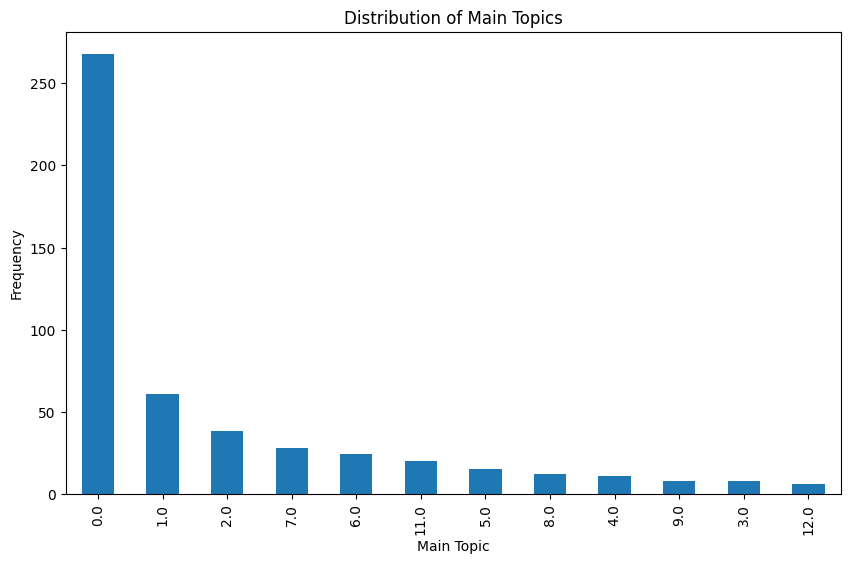

In [15]:
# The shape of `topic_encoded_df` should be (n_documents, n_topics)

# Extract main topic for each document
catalog['main_topic'] = pd.DataFrame(topic_encoded_df).idxmax(axis=1)
# Count the frequency of each main topic
topic_counts = catalog['main_topic'].value_counts()

# Create bar plot
plt.figure(figsize=(10, 6))
topic_counts.plot(kind='bar')
plt.xlabel('Main Topic')
plt.ylabel('Frequency')
plt.title('Distribution of Main Topics')
plt.show()

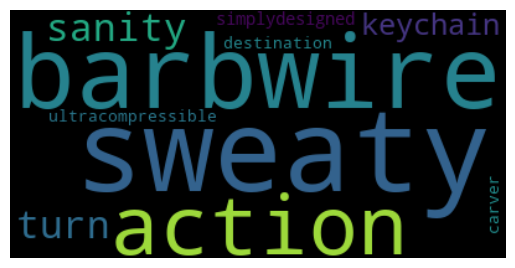

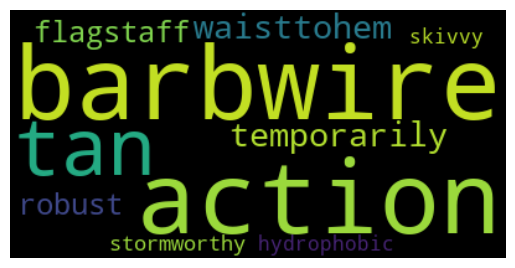

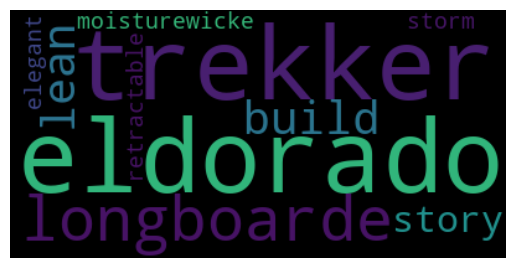

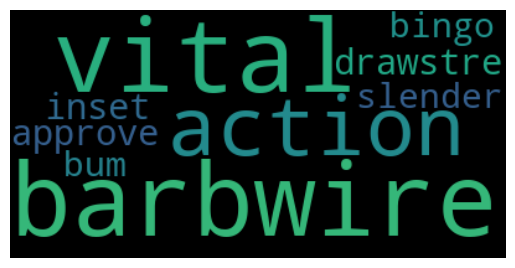

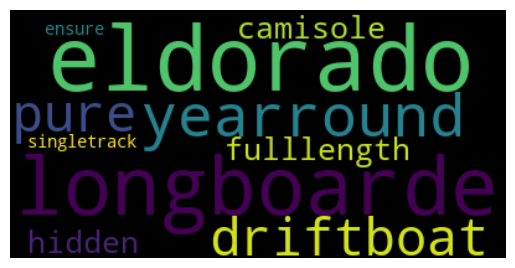

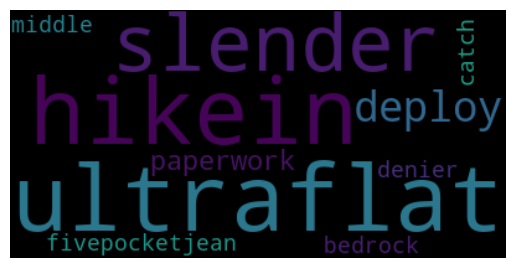

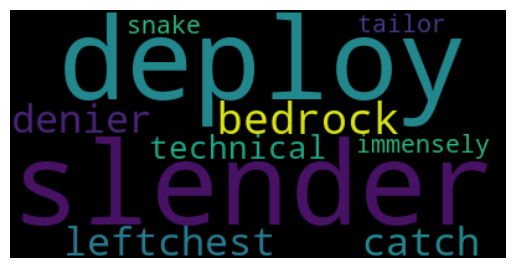

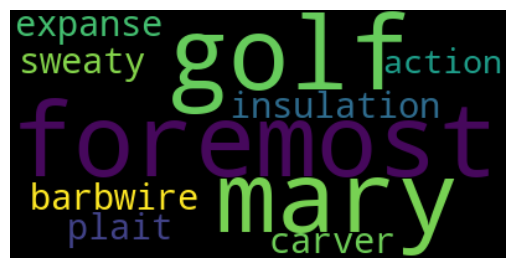

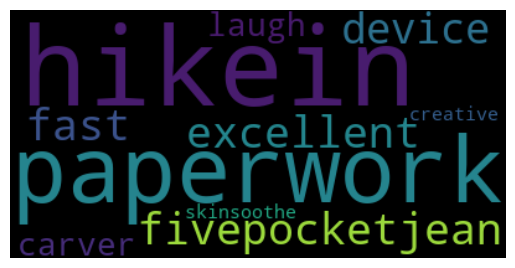

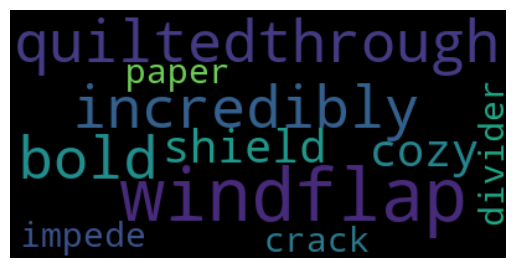

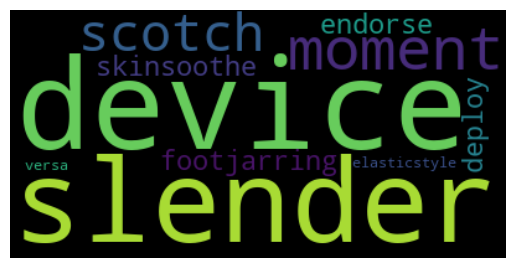

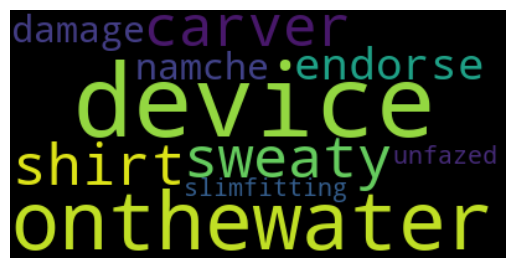

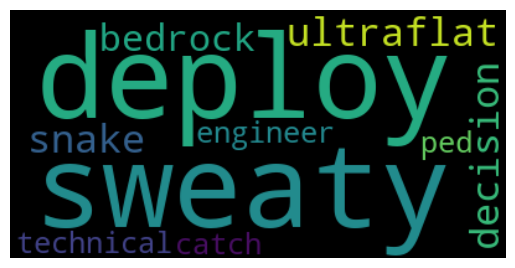

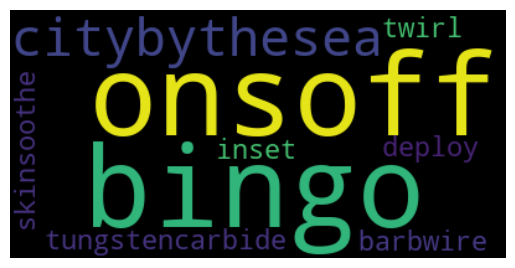

In [16]:
for i in range(n_components):
    terms = vectorizer.vocabulary_
    terms_comp = zip(terms, lsa_model.components_[i])
    sorted_terms = sorted(terms_comp, key=lambda x:x[1], reverse=True)[:10]
    wordcloud = WordCloud().generate(" ".join([term for term, wt in sorted_terms]))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()